In [1]:
from models.ticker import Ticker
from models.time_series import TimeInterval, DataType
from processing.graphing import display
from api.mongo_db import Mongo
from datetime import date
import pandas as pd
import dask.dataframe as dd

# Alpha Vantage

In [2]:
# You can initilize the class with the stock you want (setting get_name to True burns an extra API call).
ticker = Ticker("AAPL", get_name=True)

# Then you can request the data you want using the DataType ENUM. Time Interval is only used for intraday.
ticker.get_data(data_type=DataType.INTRADAY, time_interval=TimeInterval.HOUR)

# Data Representation

In [3]:
# Can be accessed as object
ticker

# as a JSON
ticker.to_json()

# or saved in CSV format
ticker.to_CSV()

# MongoDB

In [4]:
# You can download a specific ticker from Mongo if it is stored by doing
ticker = Mongo.get_ticker("AXP")

# This downloads all of the MongoDB as a list of tickers.
all_data = Mongo.download()

# You can save data to MongoDB with the following method. It only takes a Ticker class object.
Mongo.save_data(ticker)

# Download real-time data

In [5]:
# Get latest data from API
ticker = Ticker("AAPL", get_name=True)
ticker.get_data(data_type=DataType.INTRADAY, time_interval=TimeInterval.ONE)

# Save updated data if needed
# Mongo will verify if the information is duplicate, or new,
# and will update with the latest values
Mongo.save_data(ticker)

# Graphing

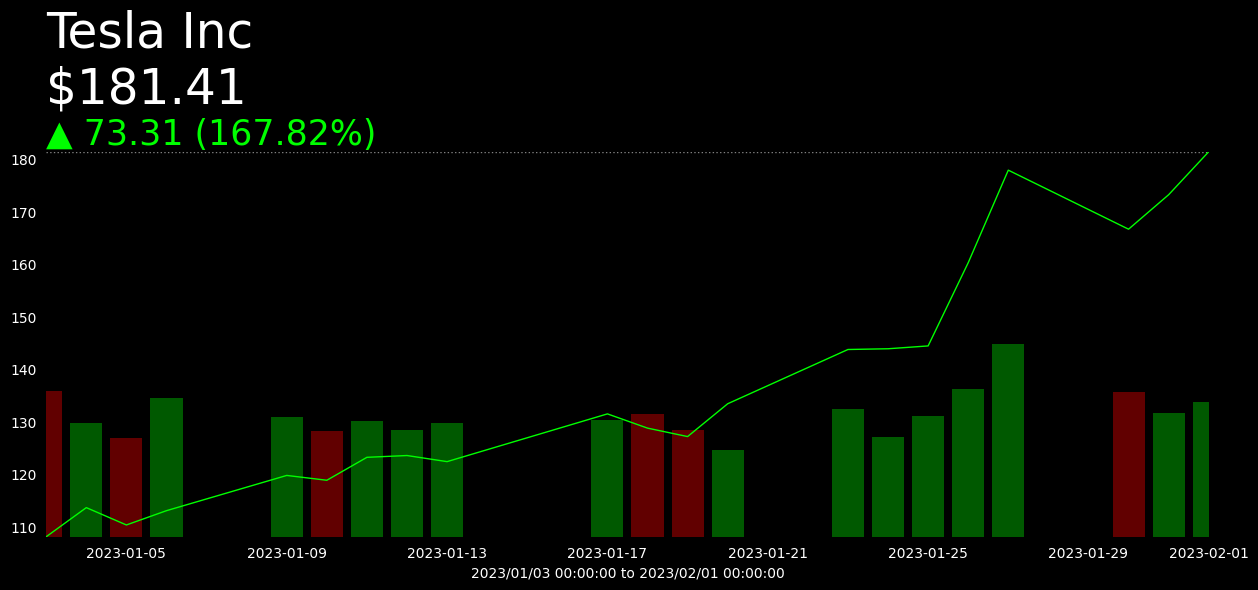

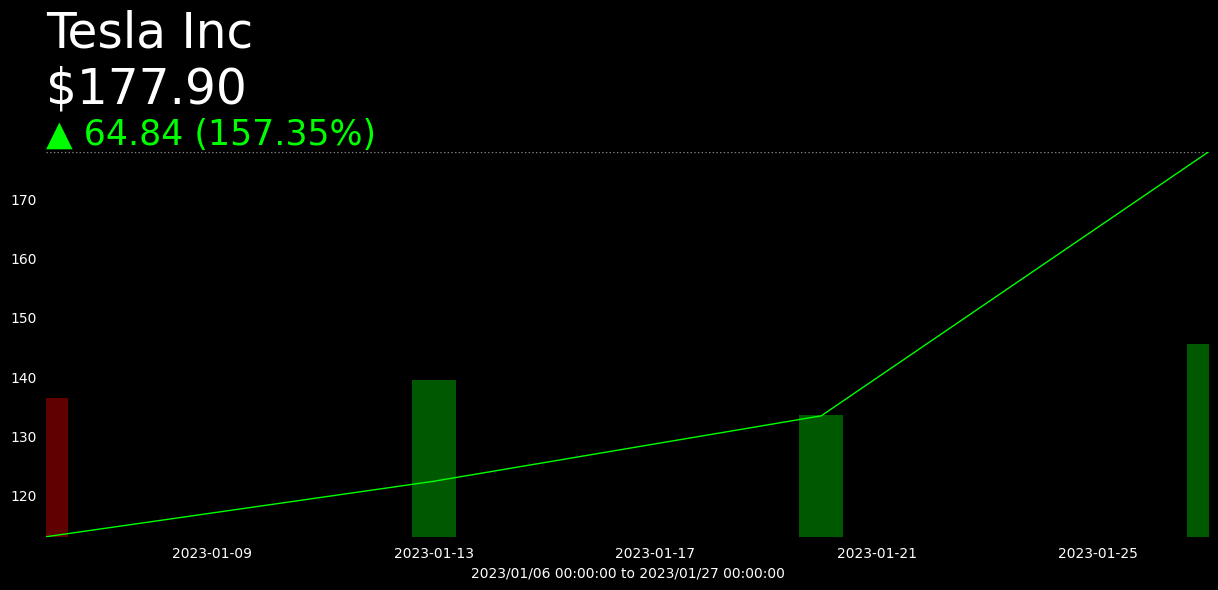

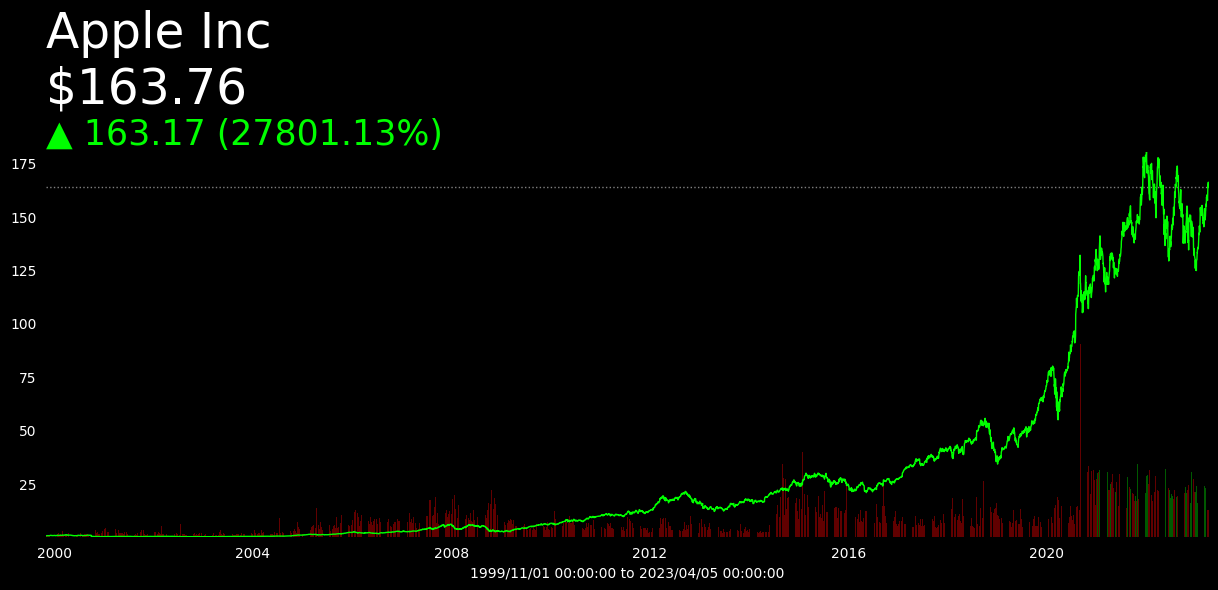

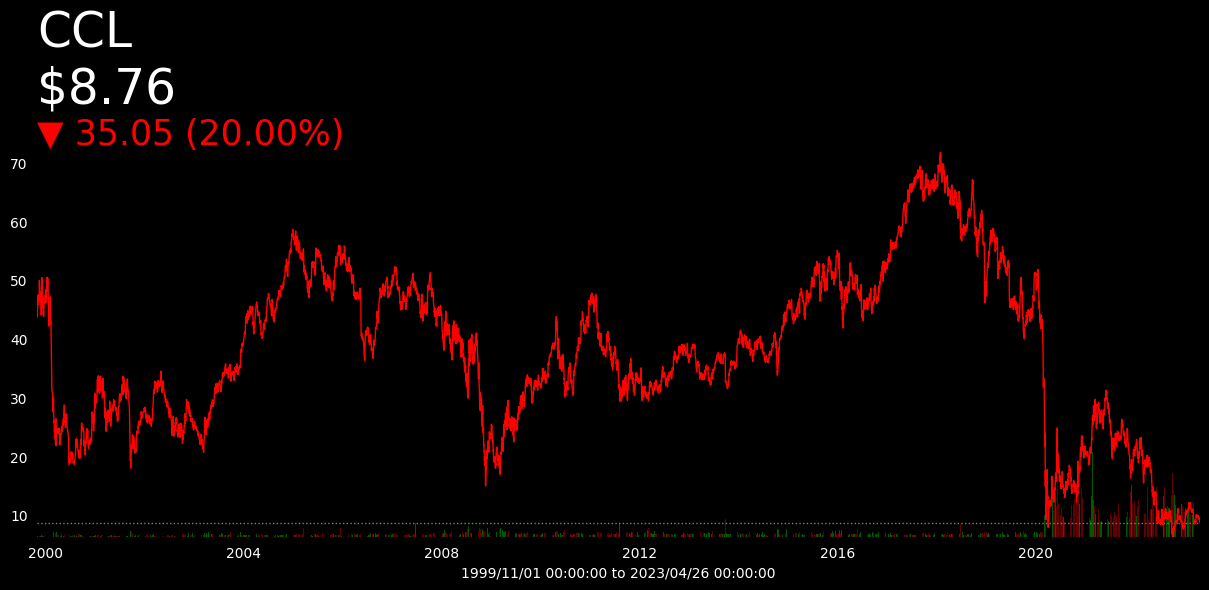

In [6]:
# We can display a graph and specify date ranges as we see fit. For example
# we can ask for Tesla stock price for Jan 2023 like so:
display("TSLA",
        start=date(year=2023, month=1, day=1),
        end=date(year=2023, month=2, day=1)
)

# By default the data will be DAILY, but we can specify if we want something else
# we can see how the graph changes if we choose weekly instead.
display("TSLA",
        kind=DataType.WEEKLY,
        start=date(year=2023, month=1, day=1),
        end=date(year=2023, month=2, day=1)
)

# If we do not specify a start or end, it will default to everything we have.
display("AAPL")

# We can also specify if we want the information updated from Alpha Vantage
# in case it is not in the database, or we wish to display more up to date info.
display("CCL", update=True)


# Outliers

Additionally, you can specify whether you'd like outliers marked on the graph. Currently there are two options, quantiles (which uses traditional quantiles to detect outliers) and isolation forests (a ML model that detects anomalies).

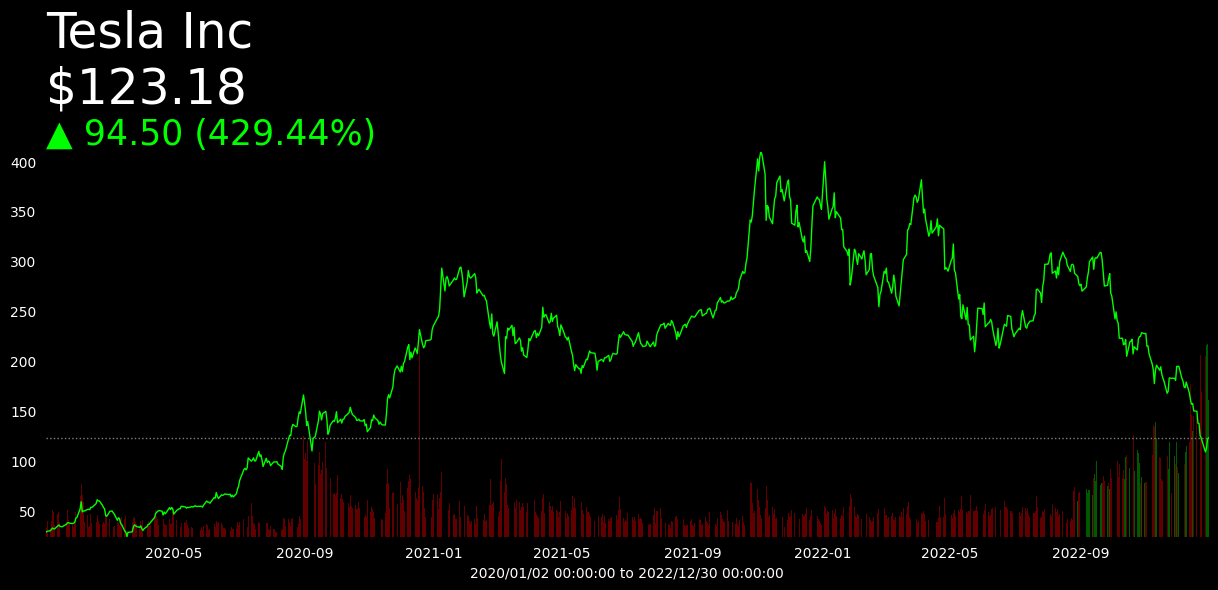

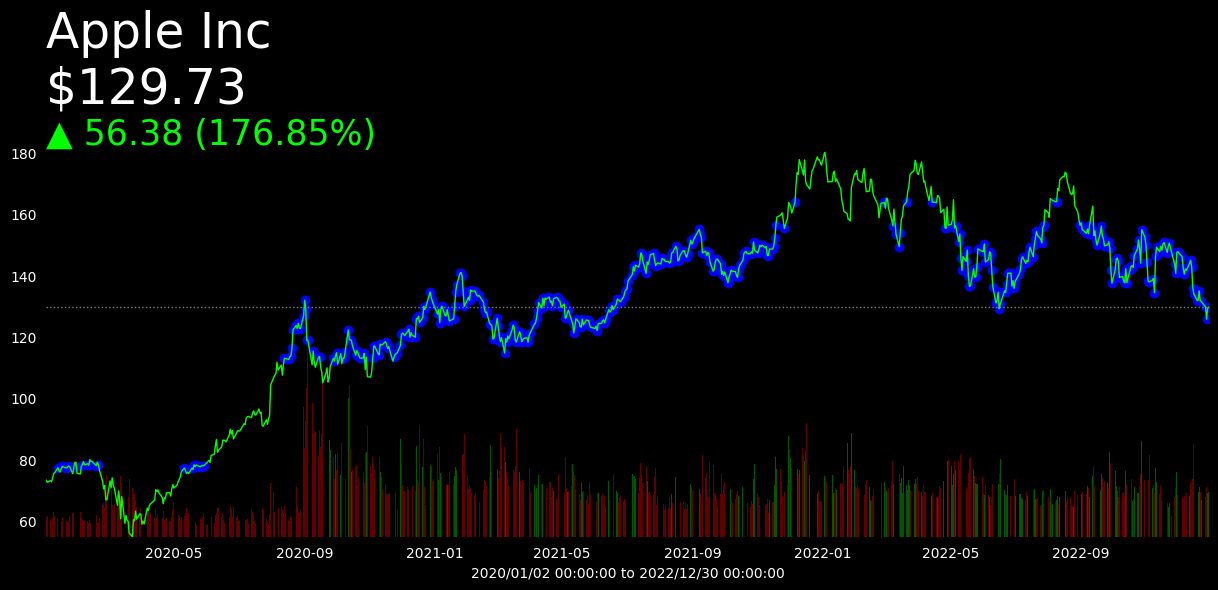

In [7]:
display(
    "TSLA",
    start=date(year=2020, month=1, day=1),
    end=date(year=2023, month=1, day=1),
    outliers='qt' # You can specify here 'qt' is for quantiles
)

display(
    "AAPL",
    start=date(year=2020, month=1, day=1),
    end=date(year=2023, month=1, day=1),
    outliers='forest' # You can specify here 'forest' is for isolation forest
)

## Compute features using Dask

In [9]:
from dask.distributed import Client
client = Client("scheduler:8786")
client

In [10]:
ticker = Ticker("AAPL", get_name=True)
ticker.get_data(data_type=DataType.INTRADAY, time_interval=TimeInterval.HOUR)
df = pd.DataFrame(ticker.time_series_data)
df.head()

,type,date,open,close,high,low,volume
0,DataType.INTRADAY,2023-04-26 20:00:00,164.00,164.03,164.03,163.75,32777
1,DataType.INTRADAY,2023-04-26 19:00:00,164.20,164.00,164.20,163.90,46909
2,DataType.INTRADAY,2023-04-26 18:00:00,164.15,164.20,164.26,164.02,1171284
3,DataType.INTRADAY,2023-04-26 17:00:00,163.74,164.18,164.50,163.65,1508573
4,DataType.INTRADAY,2023-04-26 16:00:00,163.51,163.72,164.19,163.31,8359876


In [11]:
ddf = dd.from_pandas(df, npartitions=10)
ddf

,type,date,open,close,high,low,volume
npartitions=10,,,,,,,
0,object,datetime64[ns],float64,float64,float64,float64,int64
64,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...
576,...,...,...,...,...,...,...
639,...,...,...,...,...,...,...


In [12]:
ddf.divisions

(0, 64, 128, 192, 256, 320, 384, 448, 512, 576, 639)

In [13]:
ddf.partitions[1]

,type,date,open,close,high,low,volume
npartitions=1,,,,,,,
64,object,datetime64[ns],float64,float64,float64,float64,int64
128,...,...,...,...,...,...,...


In [14]:
ddf.low.mean().compute()

158.4289090625